In [1]:
from cspe.utilities import *
import os

img_db = ImageDatabase.load_from_disk("./imagedb.pth")
state_db = StateDB.load_from_disk("./state_db.pth", max_size=1_000_000)

In [2]:
len(state_db.items)

21718

In [3]:
len(img_db.items)

4151

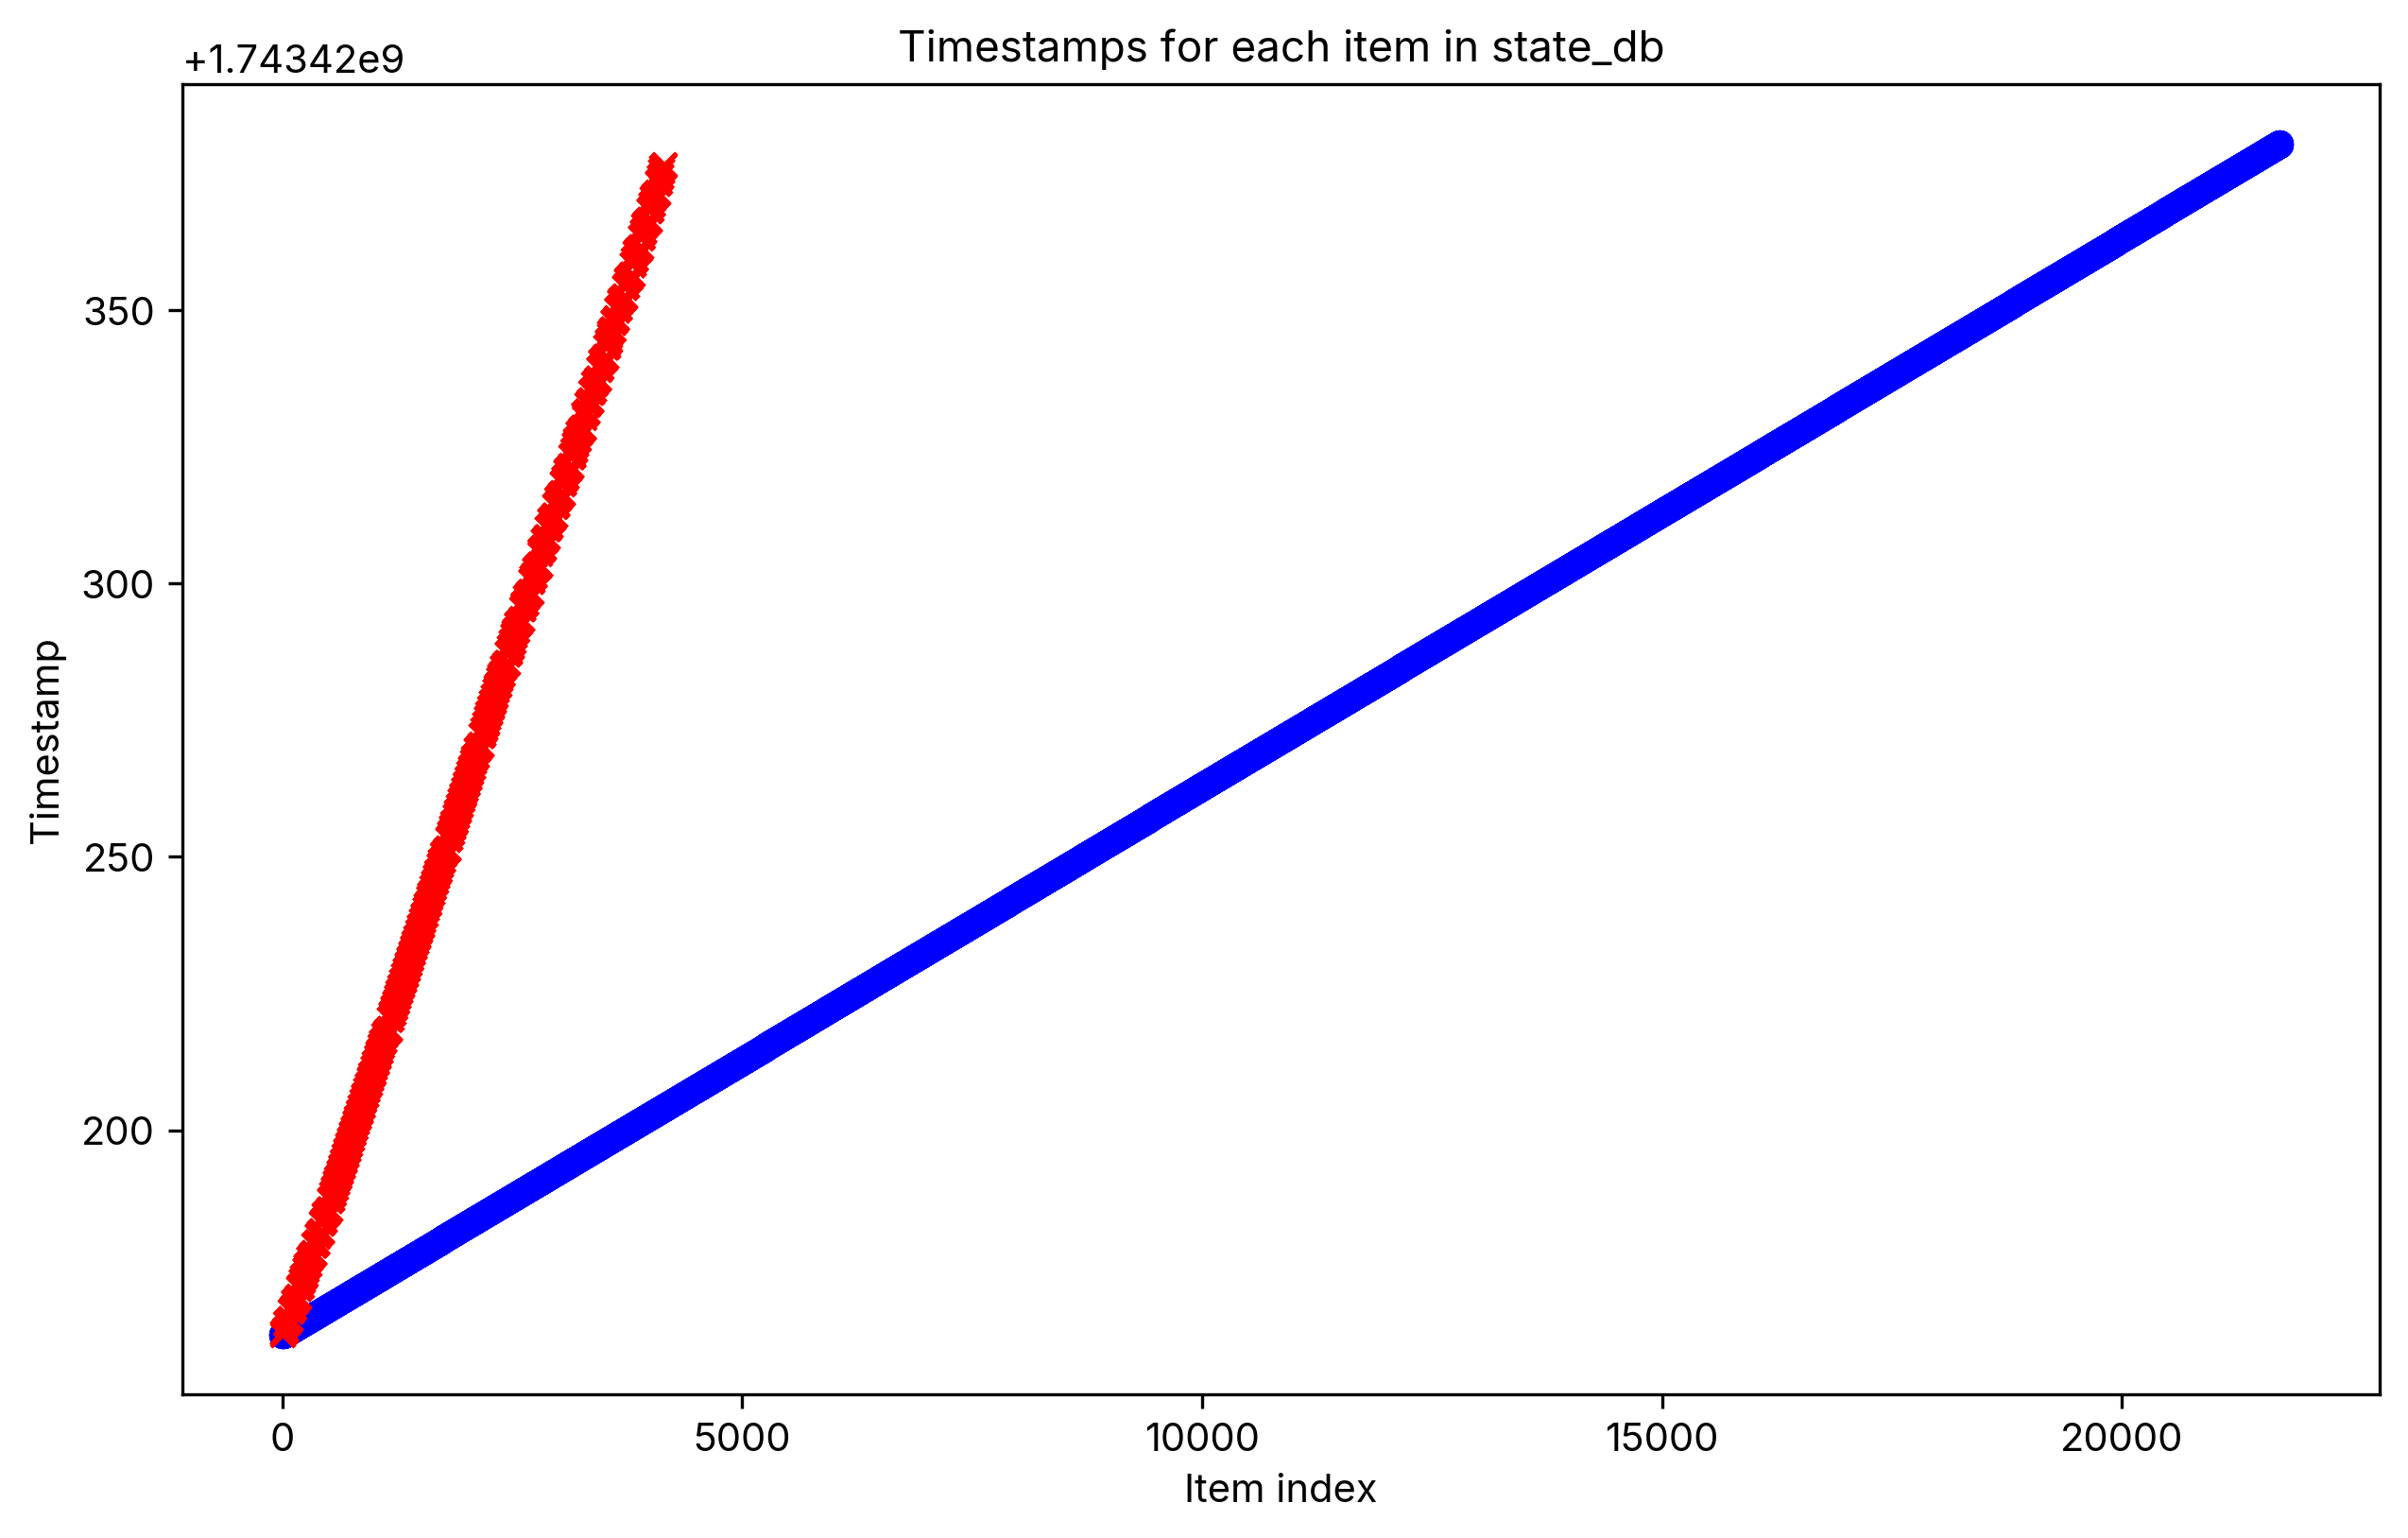

In [4]:
import matplotlib.pyplot as plt

# Extract timestamps from each state_db item
timestamps = [item['timestamp'] for item in state_db.items]
image_timestamps = [item['timestamp'] for item in img_db.items]

plt.figure(figsize=(10, 6))
plt.plot(range(len(timestamps)), timestamps, marker='o', linestyle='-', color='b', label='State DB Timestamps')
plt.plot(range(len(image_timestamps)), image_timestamps, marker='x', linestyle='--', color='r', label='Image DB Timestamps')
plt.title("Timestamps for each item in state_db")
plt.xlabel("Item index")
plt.ylabel("Timestamp")
plt.show()

In [5]:
# state_x = np.array([item['x'] for item in state_db.items])
# state_y = np.array([item['y'] for item in state_db.items])
# N = 270

# plt.figure(figsize=(8, 6))
# plt.scatter(state_x[-N:], state_y[-N:], s=10, alpha=0.7)
# plt.xlabel("X position")
# plt.ylabel("Y position")
# plt.title(f"XY positions of the last {N} timesteps")
# plt.grid(True)
# plt.show()

In [6]:
# cutoff = state_db.items[-N]['timestamp']
# print("Cutoff timestamp from state_db ([-N] item):", cutoff)

# # Keep all state_db items up to and including the [-N] item.
# new_length = len(state_db.items) - N + 1
# state_db.items = state_db.items[:new_length]
# state_db.timestamps = state_db.timestamps[:new_length]

# # In img_db, keep only items with timestamp less or equal to cutoff.
# img_db.items = [item for item in img_db.items if item['timestamp'] <= cutoff]

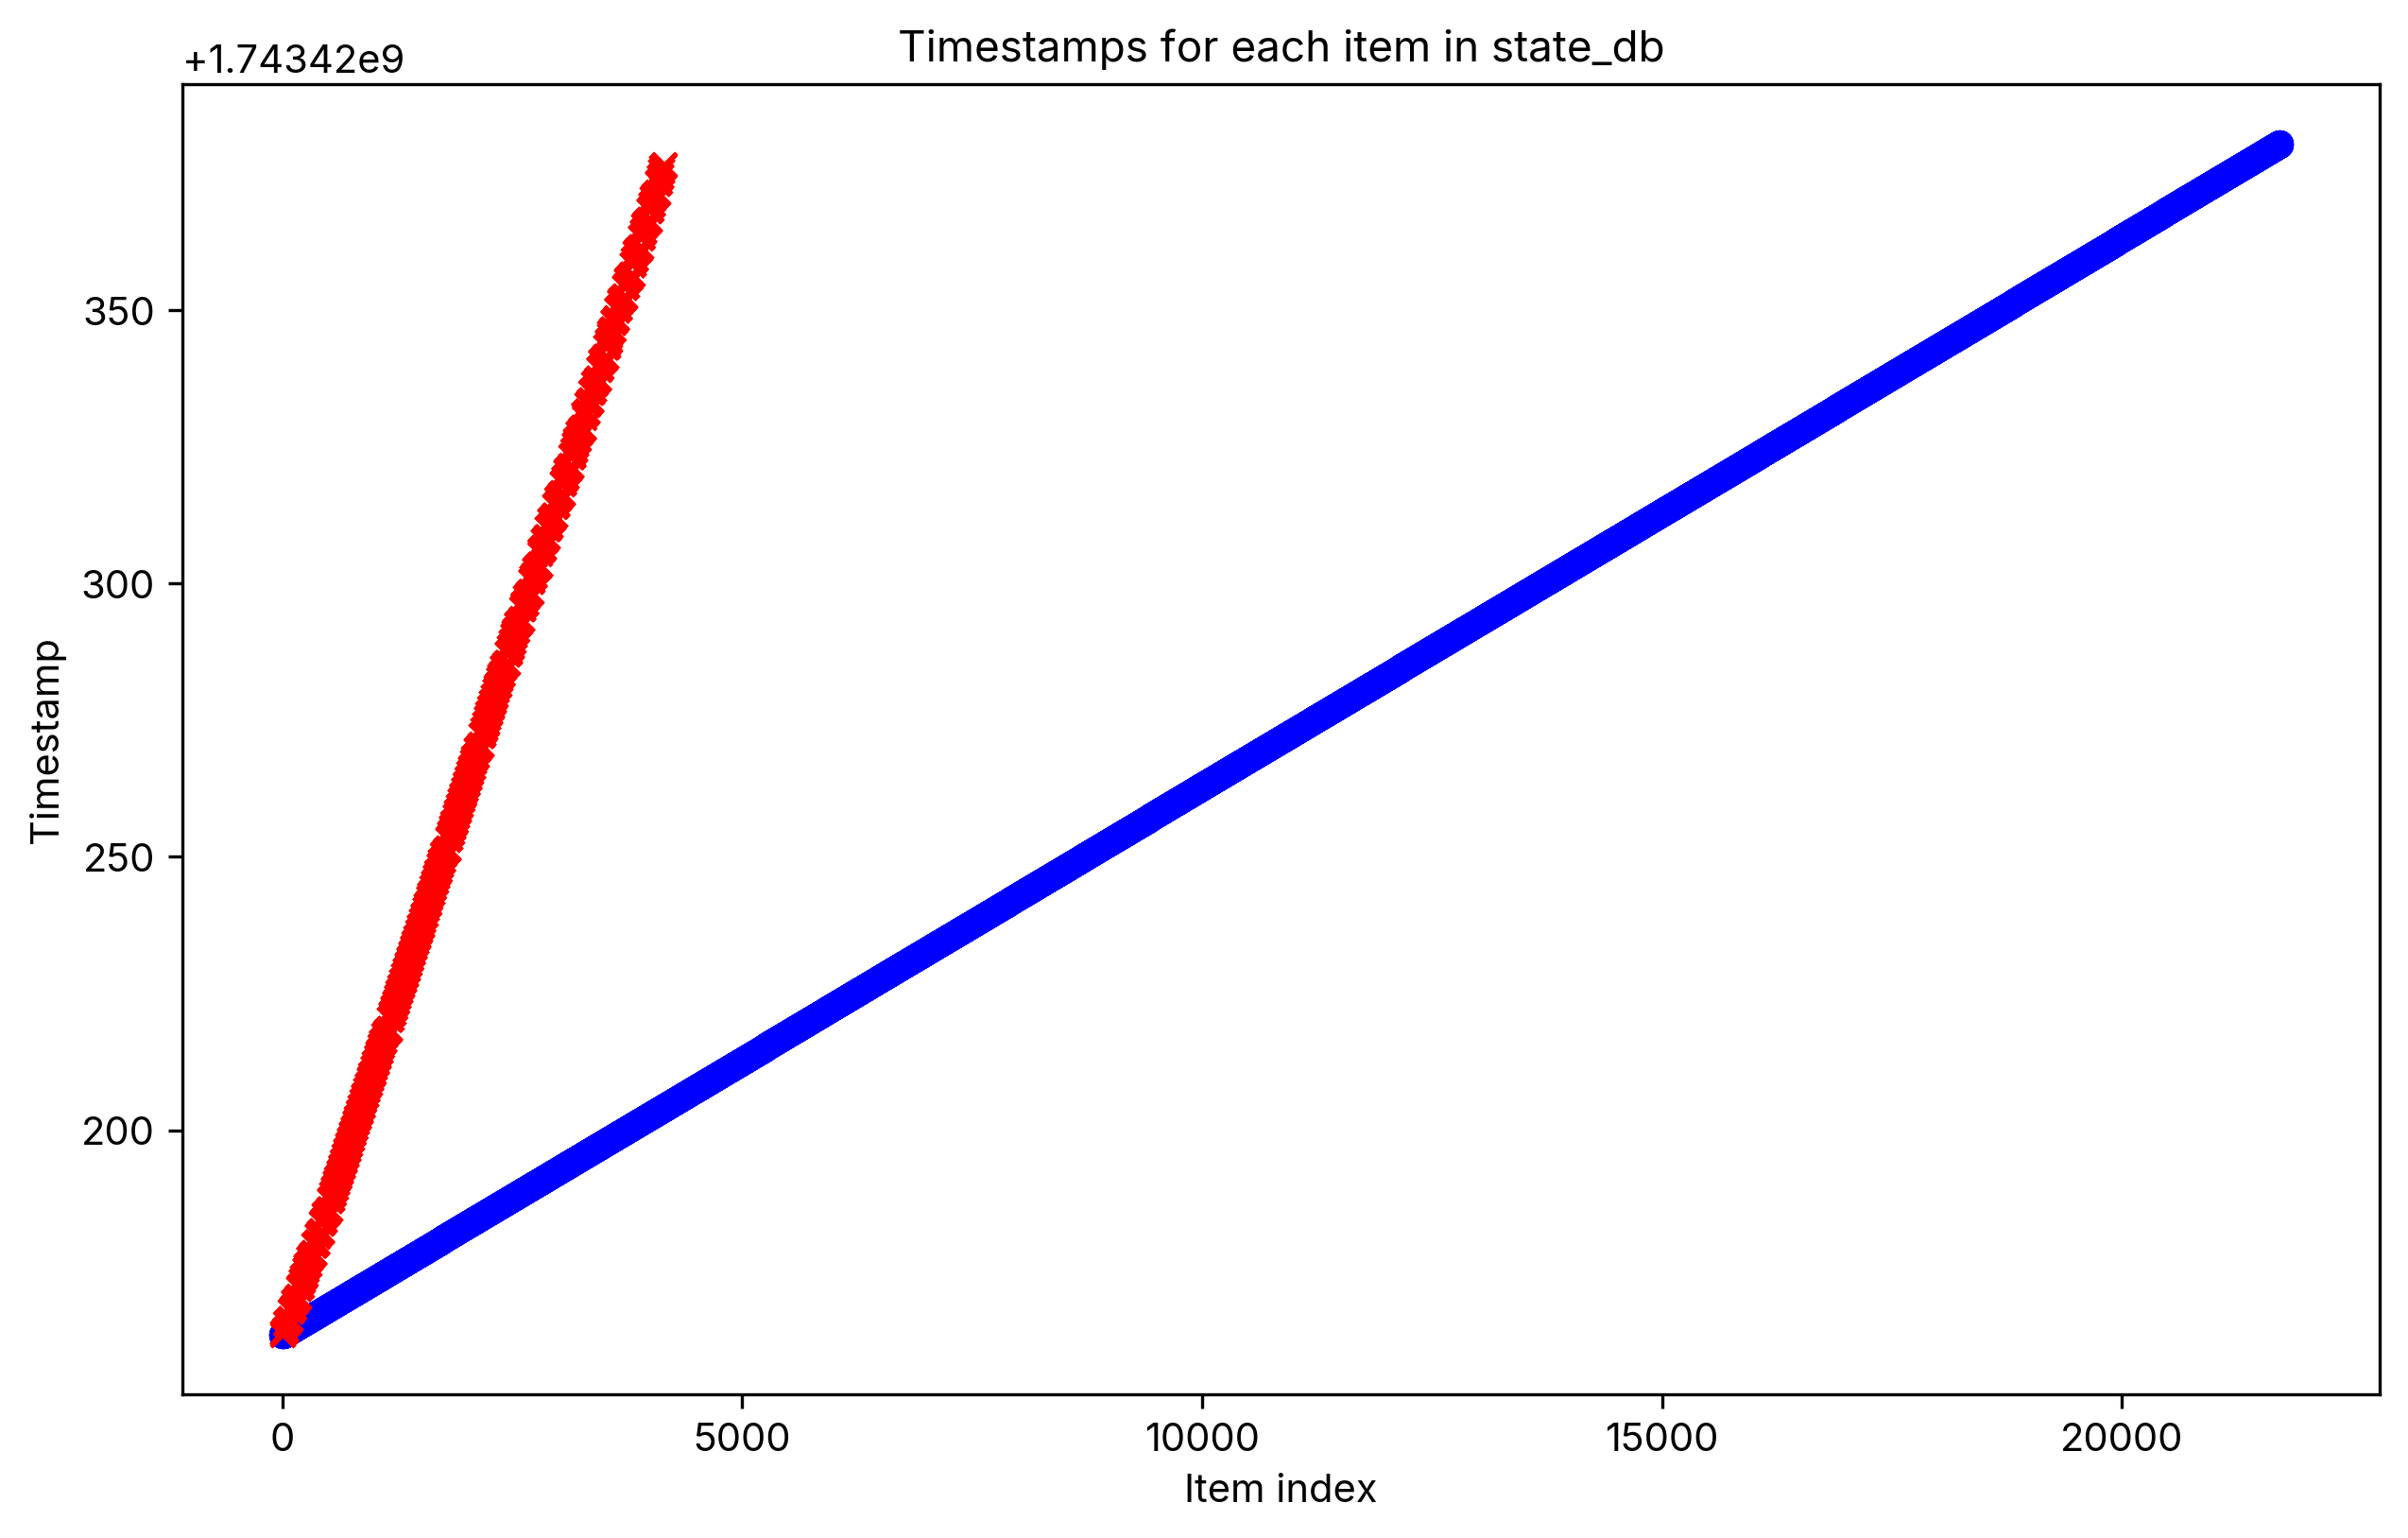

In [7]:
import matplotlib.pyplot as plt

# Extract timestamps from each state_db item
timestamps = [item['timestamp'] for item in state_db.items]
image_timestamps = [item['timestamp'] for item in img_db.items]

plt.figure(figsize=(10, 6))
plt.plot(range(len(timestamps)), timestamps, marker='o', linestyle='-', color='b', label='State DB Timestamps')
plt.plot(range(len(image_timestamps)), image_timestamps, marker='x', linestyle='--', color='r', label='Image DB Timestamps')
plt.title("Timestamps for each item in state_db")
plt.xlabel("Item index")
plt.ylabel("Timestamp")
plt.show()

In [8]:
from sklearn.cluster import HDBSCAN
import numpy as np
all_features = img_db.get_information_vectors()
# Include current feature vector for classification
all_features = np.vstack([all_features])


# Fit DBSCAN
hdbscan = HDBSCAN(
    min_cluster_size=100, n_jobs=-1, allow_single_cluster=True
)
labels = hdbscan.fit_predict(all_features)

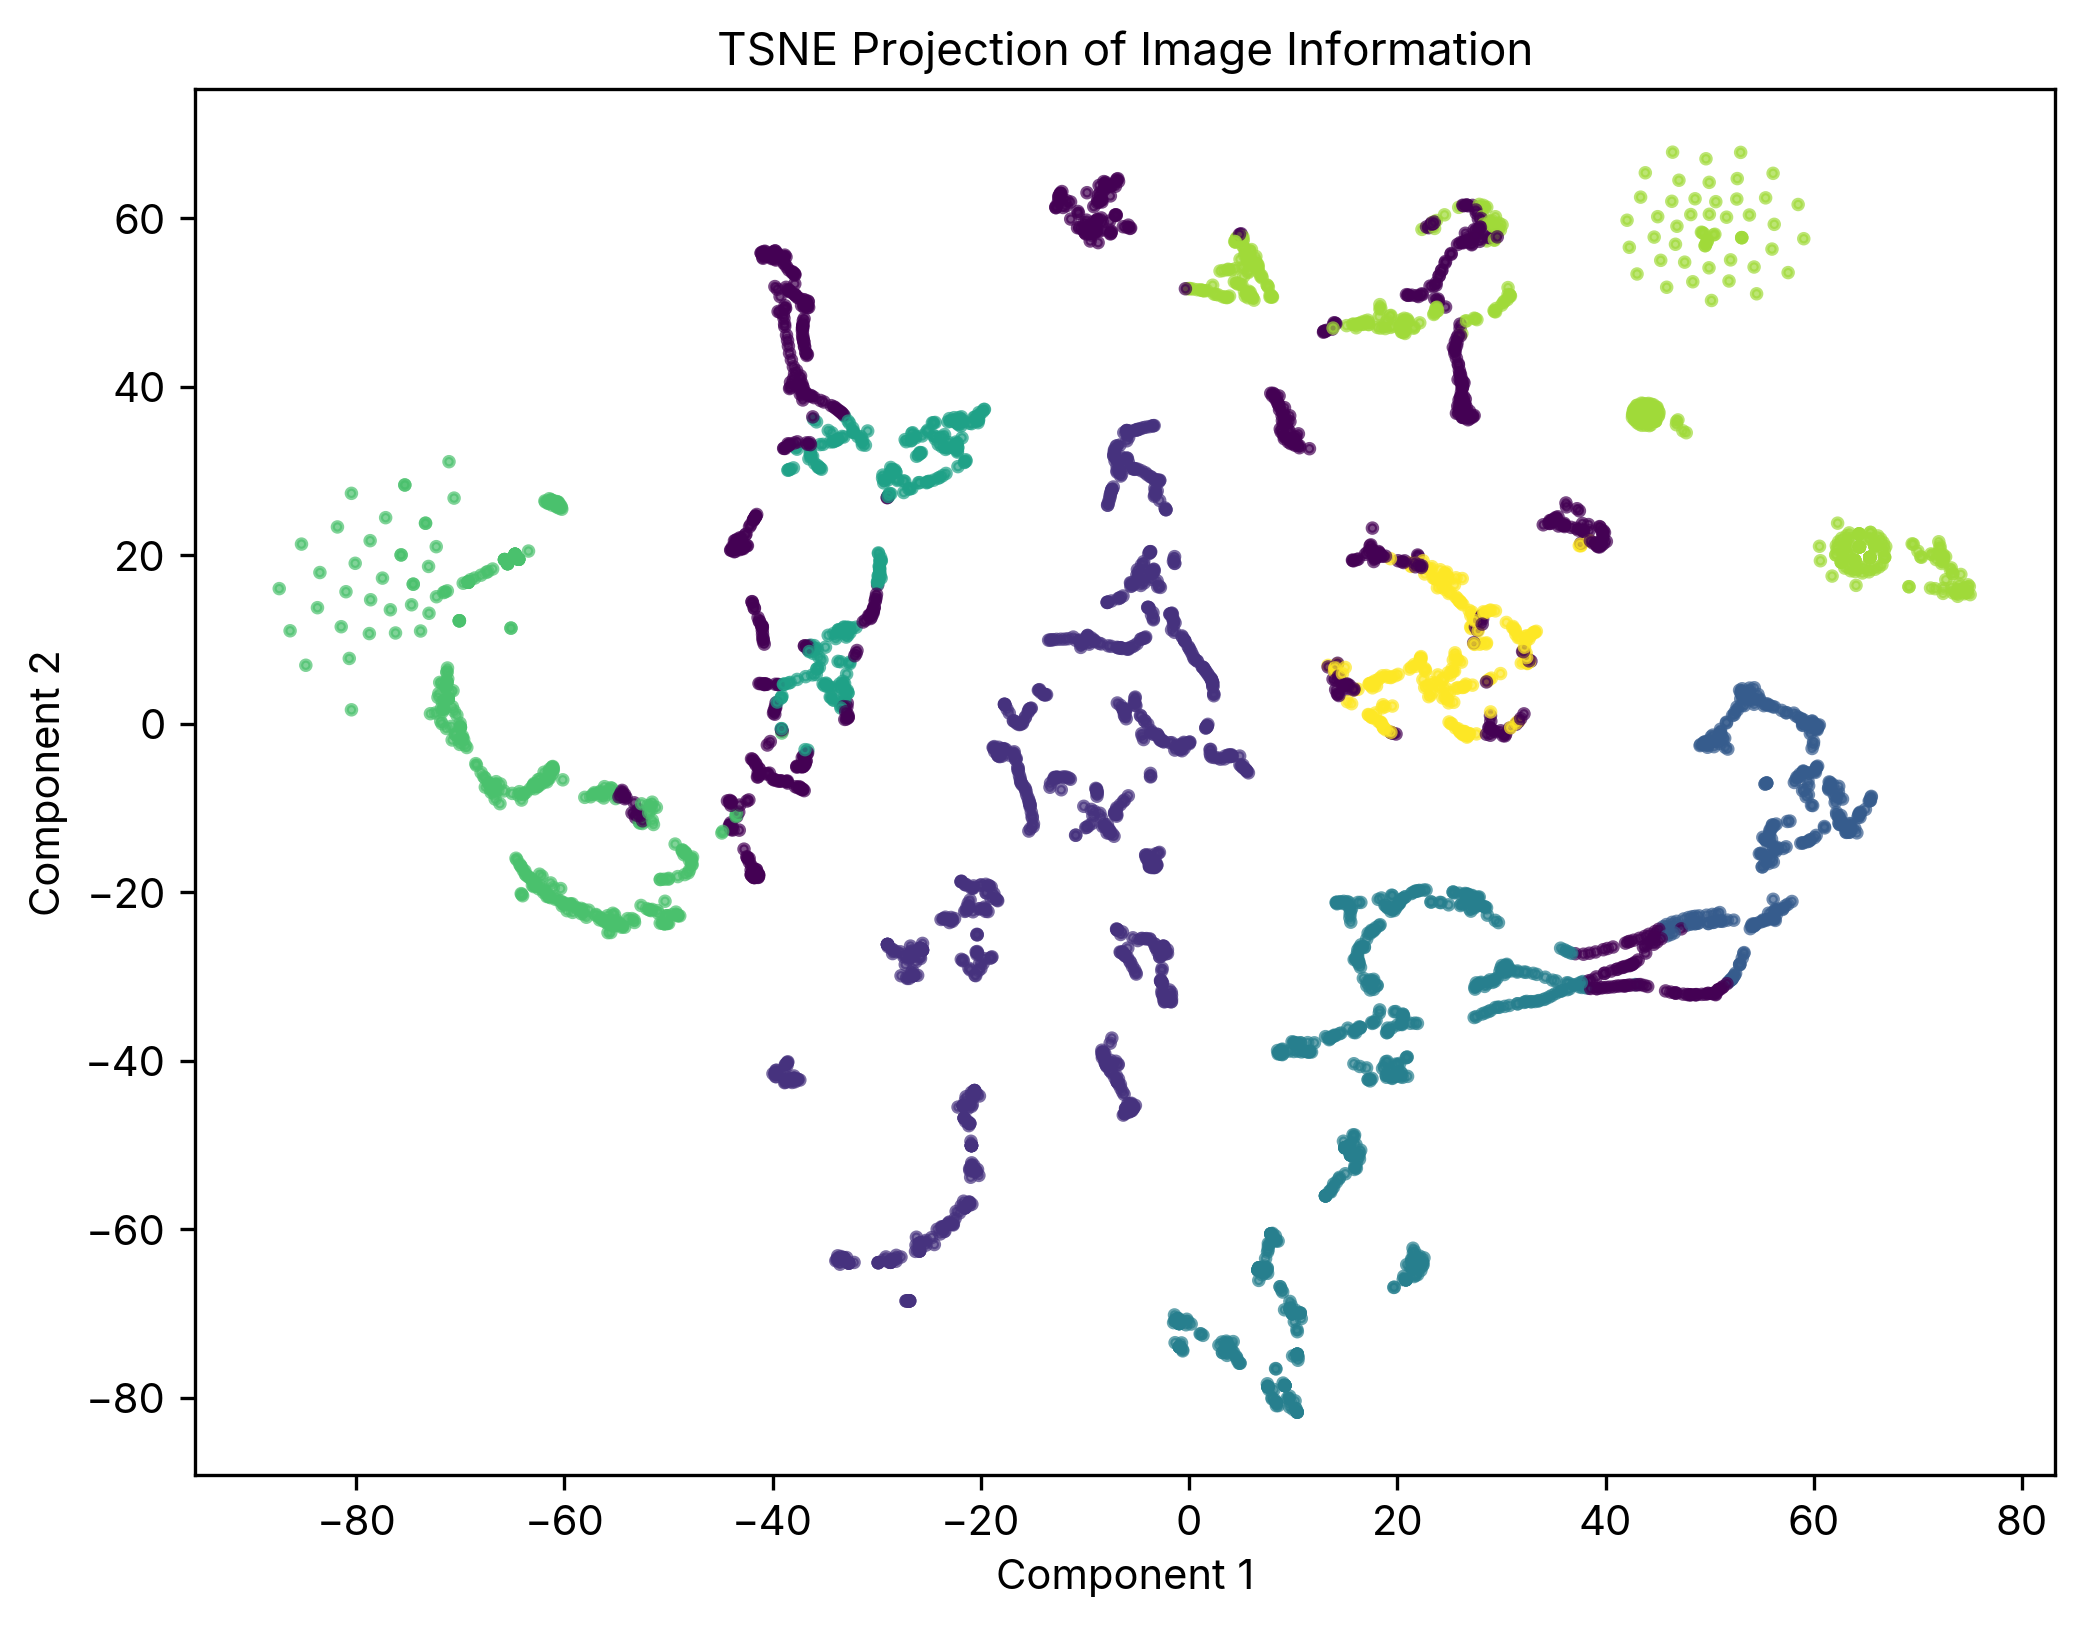

In [9]:
from sklearn.manifold import TSNE
import numpy as np

import matplotlib.pyplot as plt

# Convert the 'information' column (which contains lists) into a numpy array
X = all_features

# Apply TSNE to reduce the dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Plot the TSNE output
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', s=5, alpha=0.7)
plt.title("TSNE Projection of Image Information")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [10]:
import numpy as np
from matplotlib.colors import ListedColormap

# Convert statedb timestamps to a numpy array for fast lookup.
state_timestamps = np.array(timestamps)
state_x = []
state_y = []

# For each image timestamp, find the closest state timestamp index
for ts in image_timestamps:
    pos = np.searchsorted(state_timestamps, ts)
    if pos == 0:
        closest = 0
    elif pos == len(state_timestamps):
        closest = pos - 1
    else:
        if abs(ts - state_timestamps[pos - 1]) <= abs(ts - state_timestamps[pos]):
            closest = pos - 1
        else:
            closest = pos
    # Assuming each state item has 'x' and 'y' keys
    state_x.append(state_db.items[closest]['x'])
    state_y.append(state_db.items[closest]['y'])

state_x = np.array(state_x)
state_y = np.array(state_y)


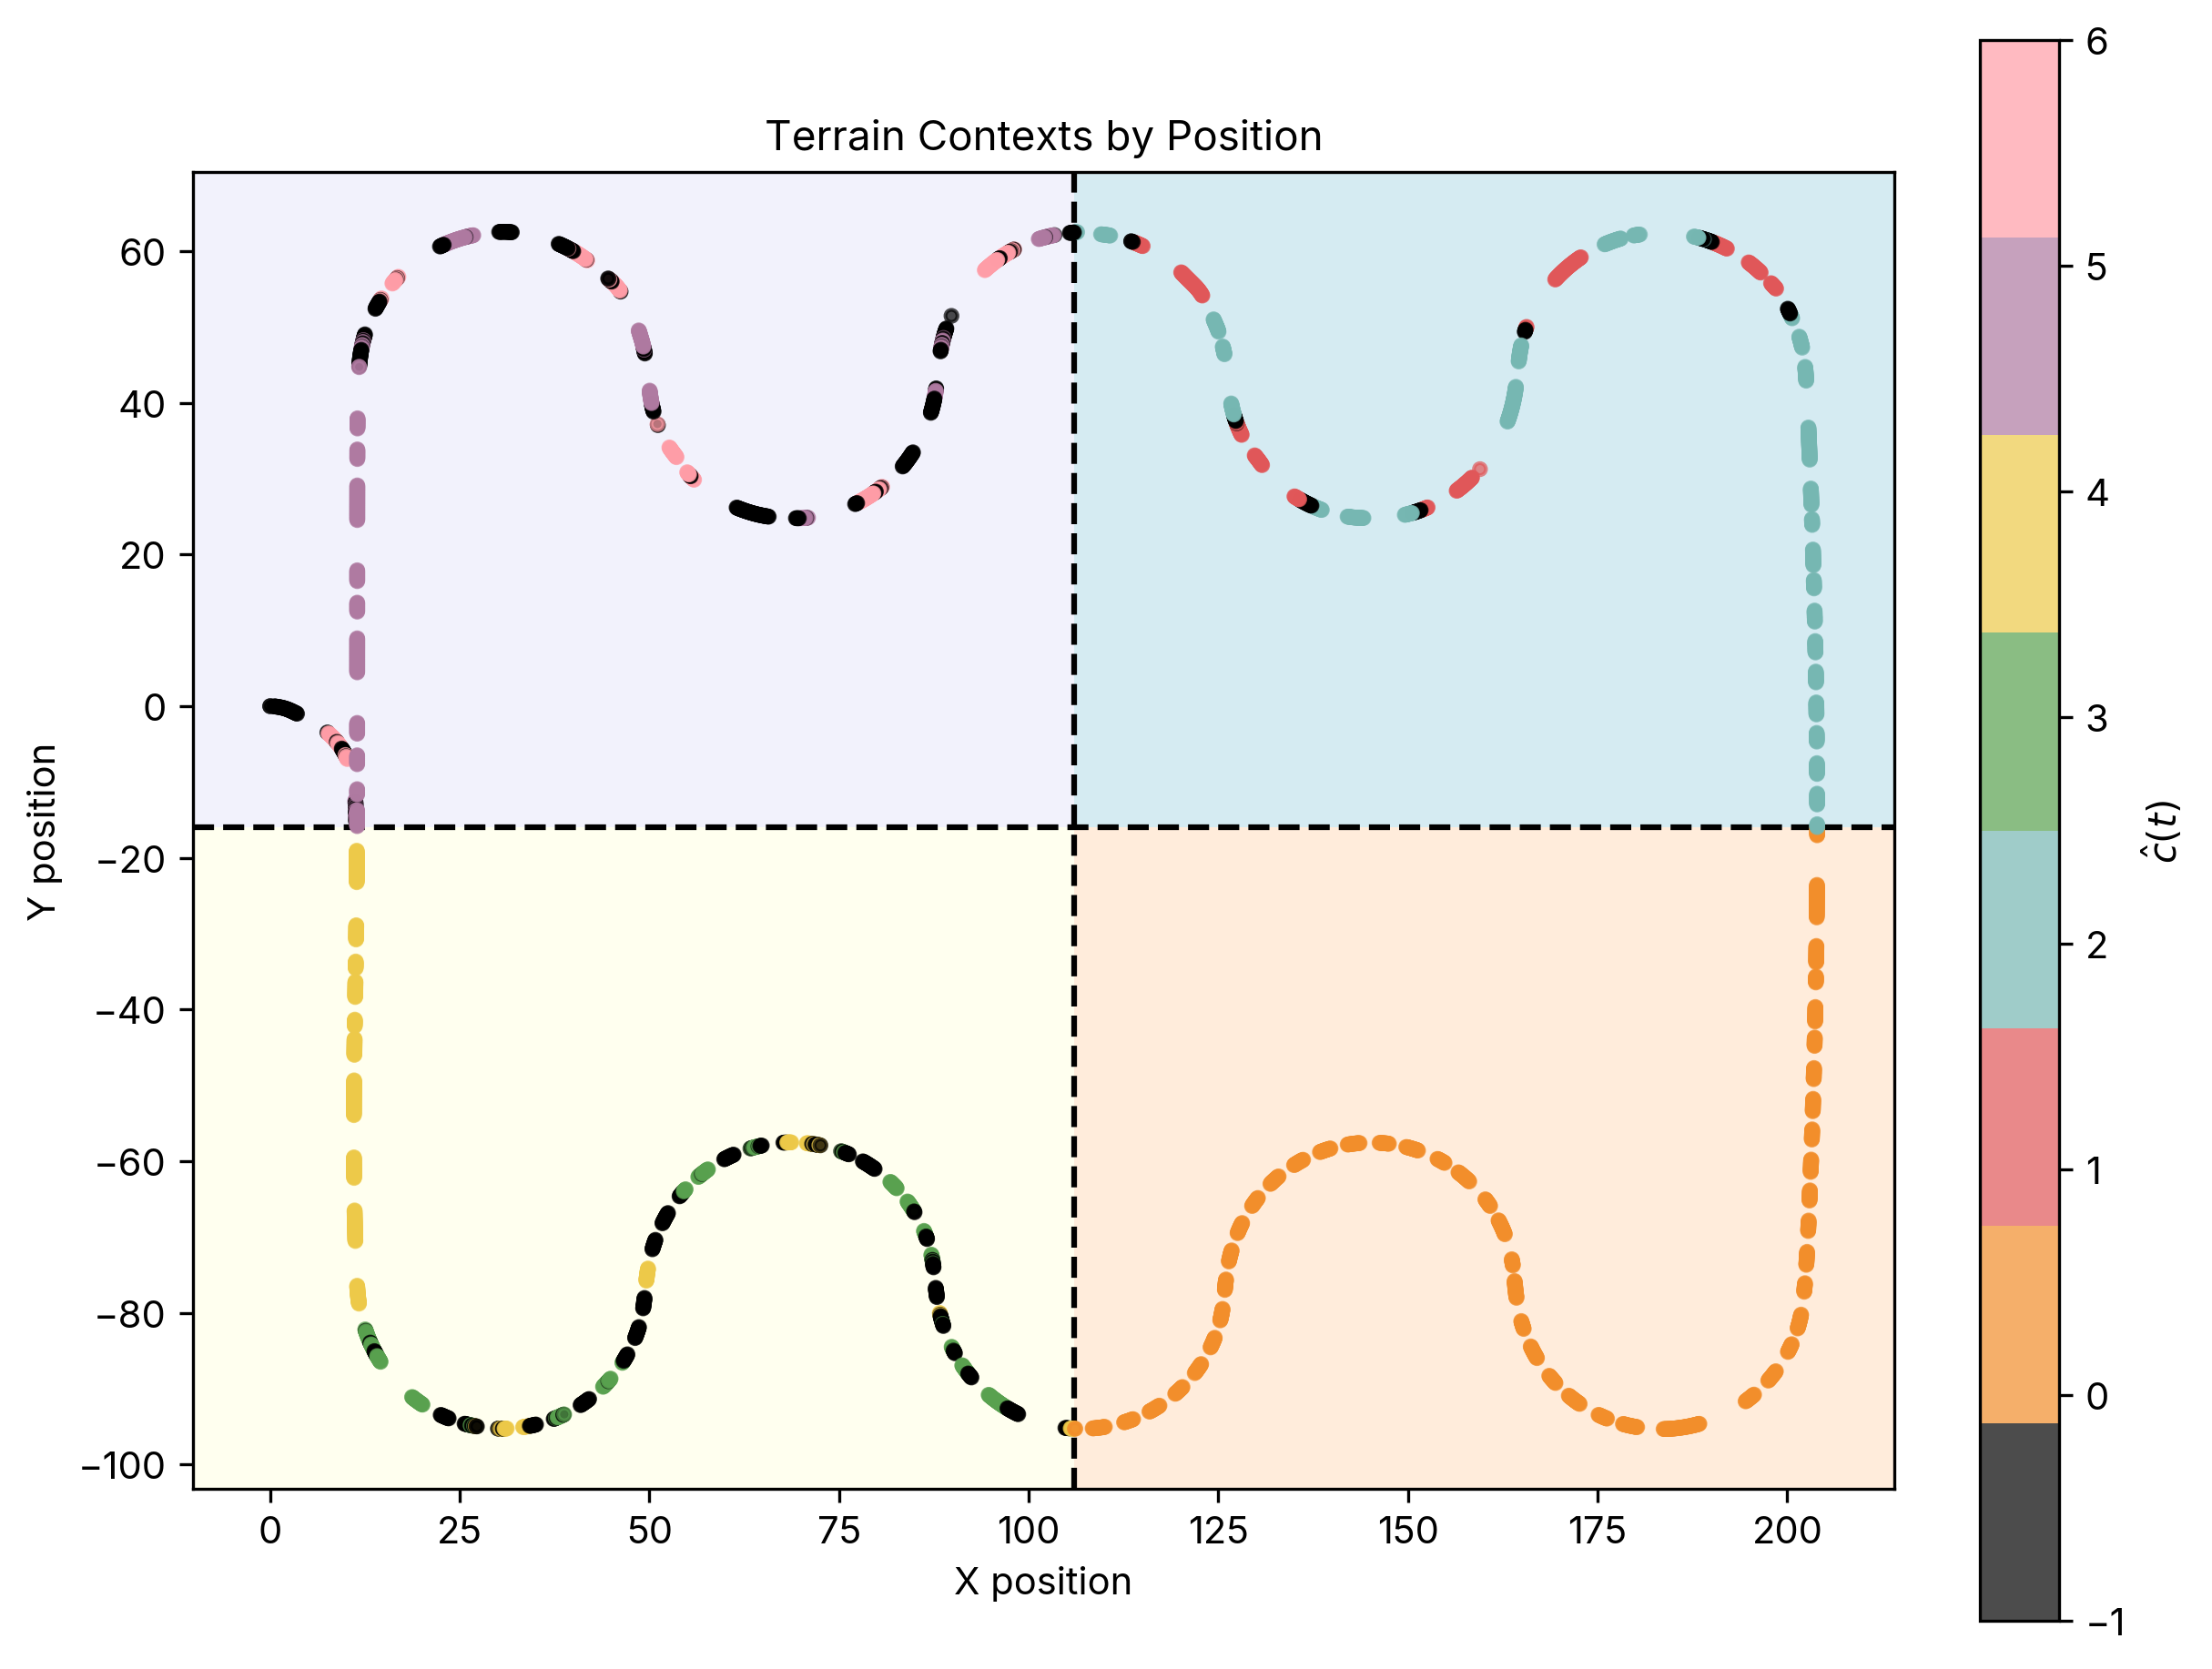

In [11]:

plt.figure(figsize=(8, 6), constrained_layout=True)
# Define Tableau 10 colors
tableau_colors = ['#000000', '#F28E2B', '#E15759', '#76B7B2', 
                  '#59A14F', '#EDC949', '#AF7AA1', '#FF9DA7', 
                  '#9C755F', '#BAB0AC']
num_colors = len(np.unique(labels))

# Create a discrete colormap using the Tableau colors.
# If there are more than 10 unique labels, fall back to the 'tab20' colormap.
if num_colors <= 10:
    discrete_cmap = ListedColormap(tableau_colors[:num_colors])
else:
    discrete_cmap = ListedColormap(plt.cm.get_cmap('tab20', num_colors).colors)

points = plt.scatter(state_x, state_y, c=labels, cmap=discrete_cmap, s=10, alpha=0.7)
plt.axvline(x=106, color='black', linestyle='--', label='x = 120')
plt.axhline(y=-16, color='black', linestyle='--', label='y = -20')

import matplotlib.patches as patches
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# Create a rectangle covering the area from (106, ylim[0]) to (xlim[1], -16)
rect = patches.Rectangle((106, ylim[0]), xlim[1] - 106, -16 - ylim[0],
                         facecolor='peachpuff', edgecolor=None, alpha=0.5)
ax.add_patch(rect)
rect2 = patches.Rectangle((106, -16), xlim[1] - 106, ylim[1] - (-16),
                           facecolor='lightblue', edgecolor=None, alpha=0.5)
ax.add_patch(rect2)
rect3 = patches.Rectangle((xlim[0], -16), 106 - xlim[0], ylim[1] - (-16),
                           facecolor='#E6E6FA', edgecolor=None, alpha=0.5)
ax.add_patch(rect3)

rect4 = patches.Rectangle((xlim[0], ylim[0]), 106 - xlim[0], -16 - ylim[0],
                           facecolor='lightyellow', edgecolor=None, alpha=0.5)
ax.add_patch(rect4)

points.set_zorder(10)
ax.set_aspect('equal', adjustable='box')

plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Terrain Contexts by Position")
plt.colorbar(label="$\hat{c}(t)$")
plt.savefig("terrain_contexts.pdf", dpi=300, bbox_inches='tight')
plt.show()

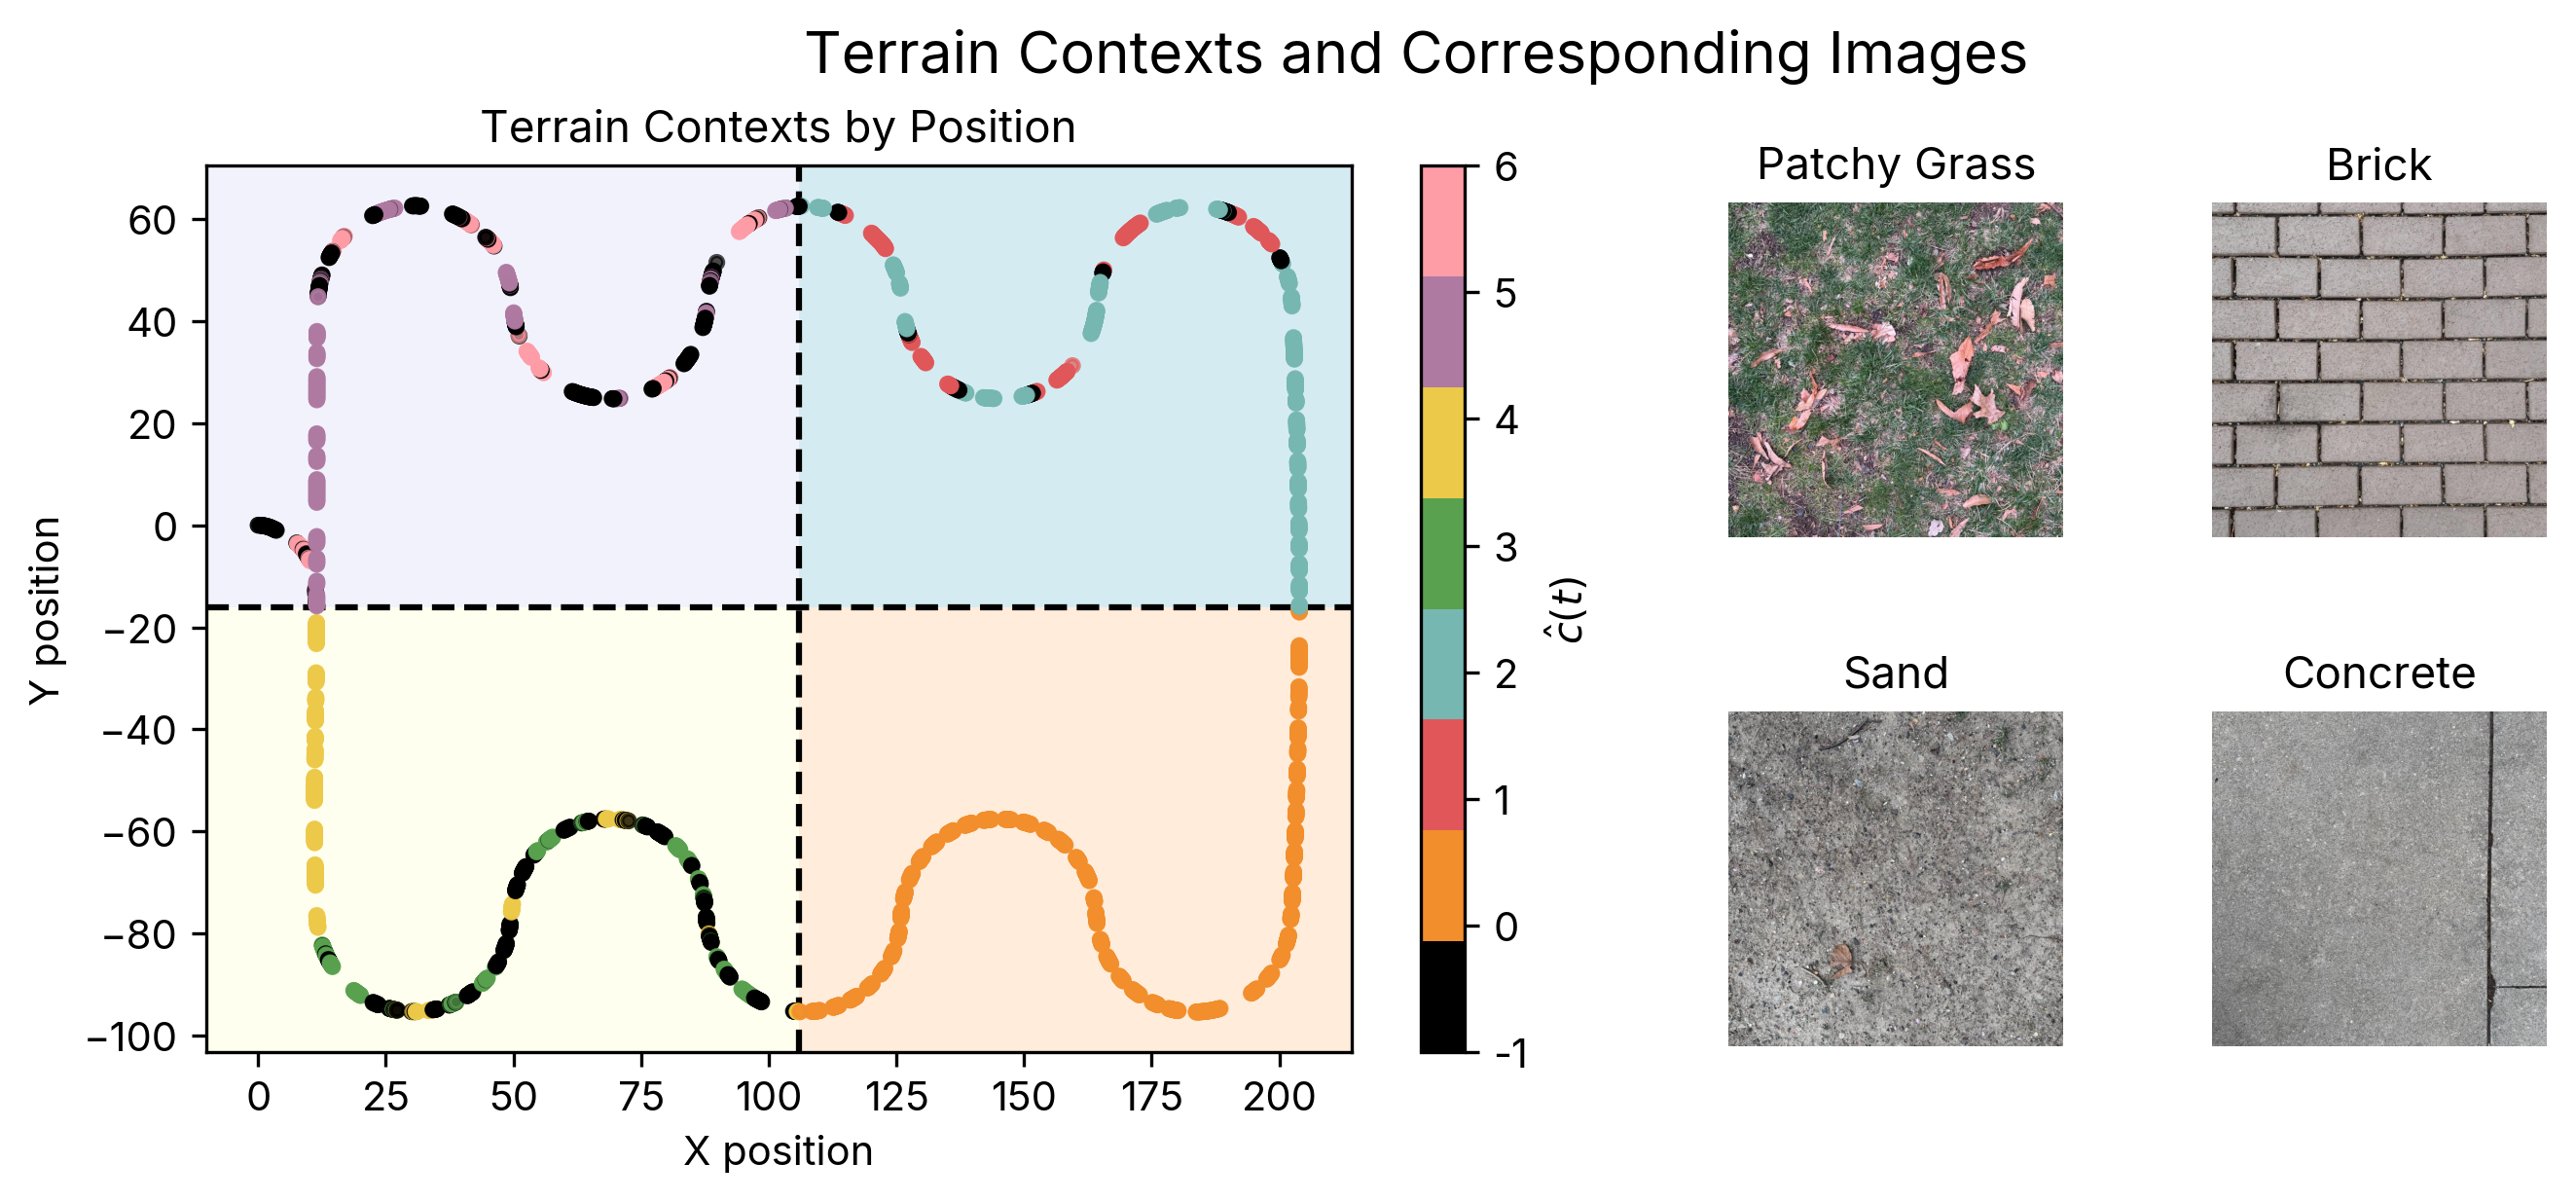

In [12]:
# Create a new figure with twice the width (here 16 by 8 inches)
fig = plt.figure(figsize=(10, 4), constrained_layout=True, dpi=300)
# Create a gridspec with 1 row and 2 columns
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.3, 1], wspace=0.3)

# LEFT: Terrain Contexts by Position (similar to cell 9)
ax_left = fig.add_subplot(gs[0, 0])
points = ax_left.scatter(state_x, state_y, c=labels, cmap=discrete_cmap, s=10, alpha=0.7)
ax_left.axvline(x=106, color='black', linestyle='--', label='x = 120')
ax_left.axhline(y=-16, color='black', linestyle='--', label='y = -20')
# Get current limits for rectangle placement
curr_xlim = ax_left.get_xlim()
curr_ylim = ax_left.get_ylim()
rect = patches.Rectangle((106, curr_ylim[0]), curr_xlim[1]-106, -16-curr_ylim[0],
                         facecolor='peachpuff', edgecolor=None, alpha=0.5)
ax_left.add_patch(rect)
rect2 = patches.Rectangle((106, -16), curr_xlim[1]-106, curr_ylim[1]-(-16), 
                          facecolor='lightblue', edgecolor=None, alpha=0.5)
ax_left.add_patch(rect2)
rect3 = patches.Rectangle((curr_xlim[0], -16), 106-curr_xlim[0], curr_ylim[1]-(-16),
                          facecolor='#E6E6FA', edgecolor=None, alpha=0.5)
ax_left.add_patch(rect3)
rect4 = patches.Rectangle((curr_xlim[0], curr_ylim[0]), 106-curr_xlim[0], -16-curr_ylim[0],
                          facecolor='lightyellow', edgecolor=None, alpha=0.5)
ax_left.add_patch(rect4)
points.set_zorder(10)
ax_left.set_aspect('equal', adjustable='box')
ax_left.set_xlabel("X position")
ax_left.set_ylabel("Y position")
ax_left.set_title("Terrain Contexts by Position")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=discrete_cmap), ax=ax_left, label="$\hat{c}(t)$")
unique_labels = np.unique(labels)
cbar.set_ticks(np.linspace(0, 1, len(unique_labels)))
cbar.set_ticklabels(unique_labels)

# RIGHT: Four square images arranged in a 2x2 grid.
# Use a subgridspec for the right cell.
gs_right = gs[0, 1].subgridspec(2, 2, wspace=0.3, hspace=0.3)
root_path = "/FrictionEstimation/ros/src/common_road_sim/resource/textures/"
image_paths = ["PatchyGrass.jpg", "Brick.jpg", "Sand.jpg", "Concrete.jpg"]
image_titles = ["Patchy Grass", "Brick", "Sand", "Concrete"]

for i, image_file in enumerate(image_paths):
    ax_img = fig.add_subplot(gs_right[i // 2, i % 2])
    file_path = os.path.join(root_path, image_file)
    try:
        image = plt.imread(file_path)
    except Exception as e:
        image = np.random.rand(100, 100, 3)  # Fallback dummy image
    ax_img.imshow(image)
    ax_img.axis("off")
    # Expand the axis to make the image larger
    box = ax_img.get_position()
    ax_img.set_position([box.x0, box.y0, box.width * 0.9, box.height * 0.9])
    ax_img.set_title(f"{image_titles[i]}")

plt.suptitle("Terrain Contexts and Corresponding Images")
plt.savefig("terrain_contexts_with_images.pdf", dpi=300, bbox_inches='tight')
plt.show()

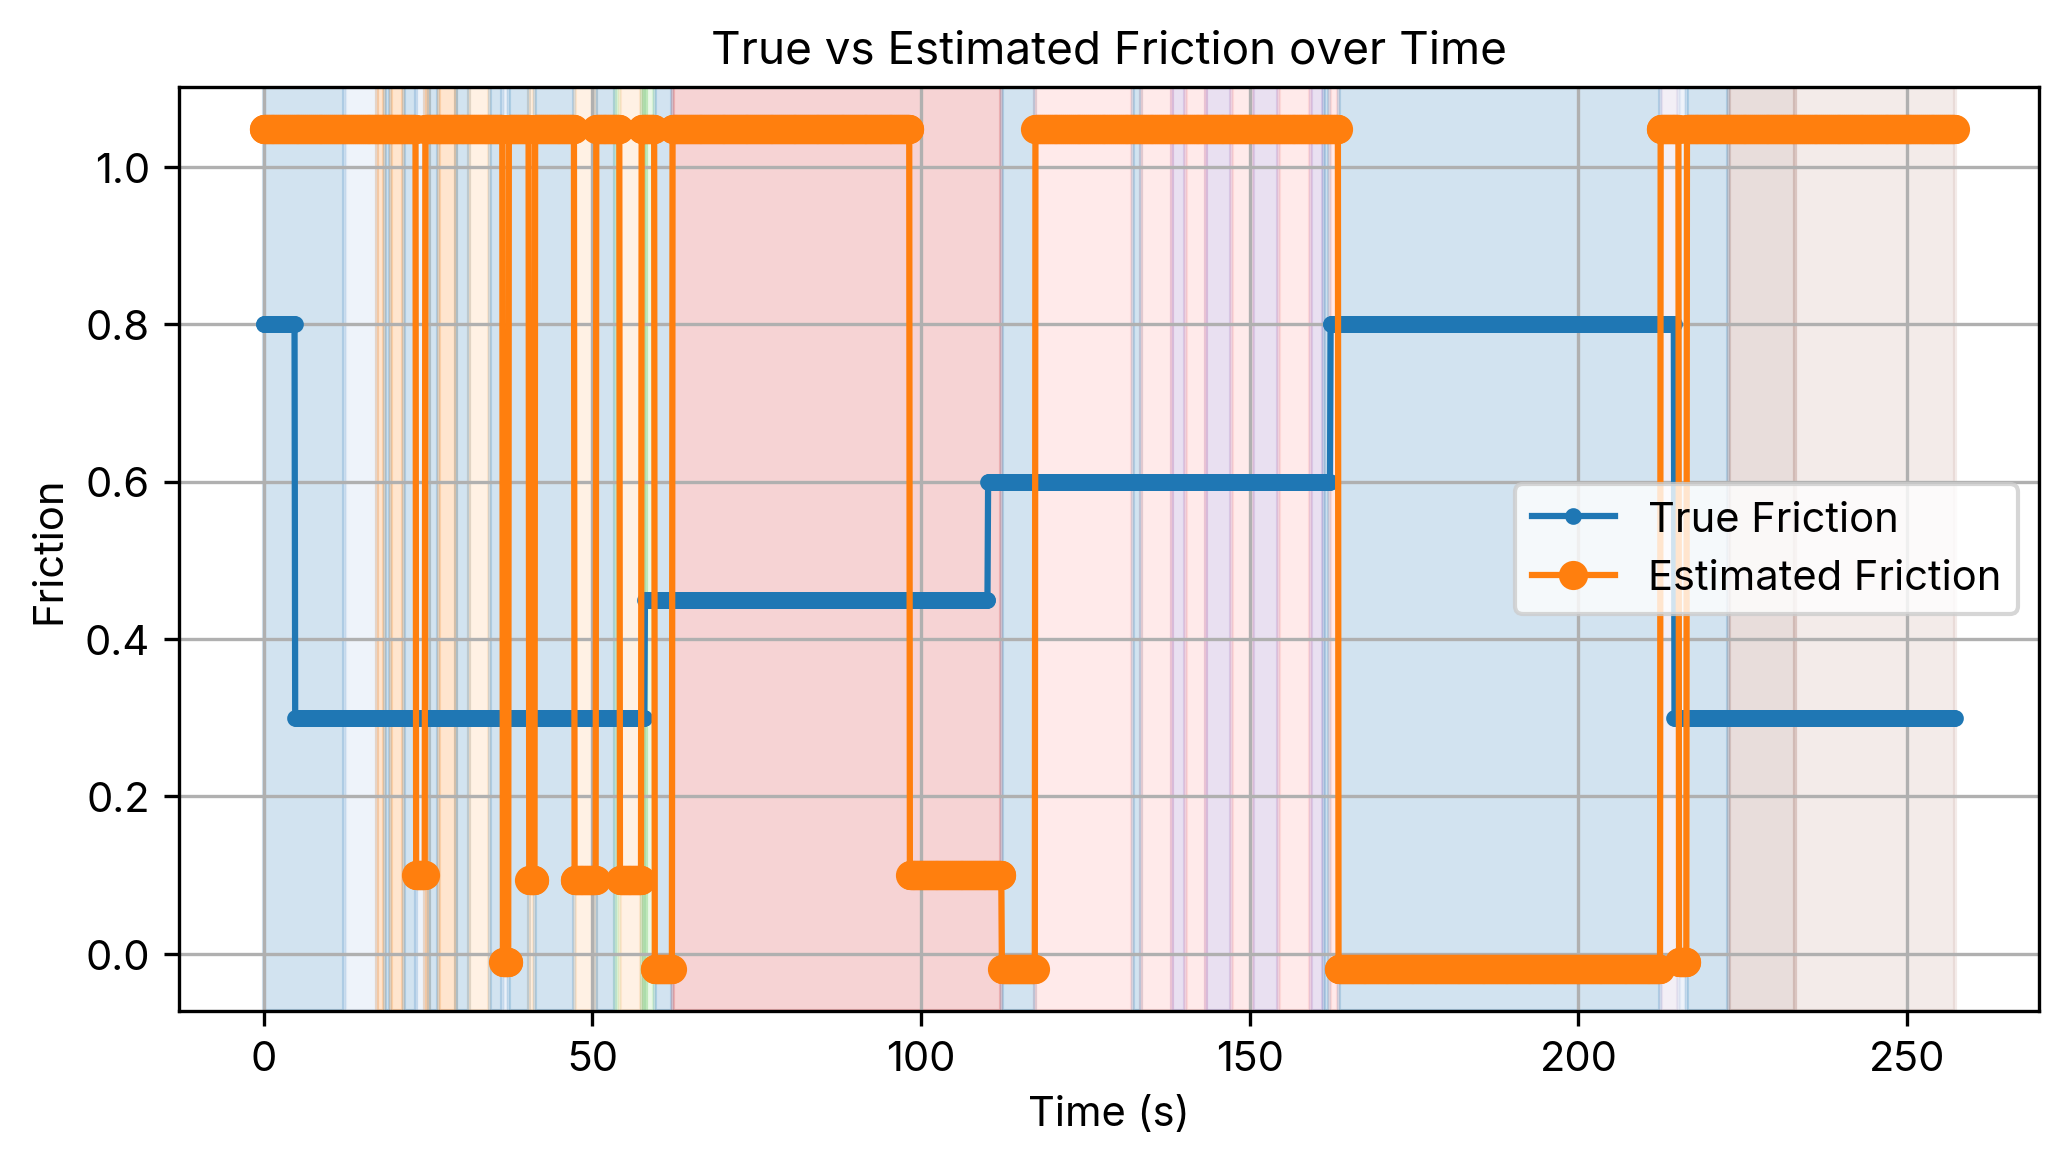

In [29]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("friction_log_20250331_114825.csv")
df['time'] = df['time'] - df['time'].min()
# Plot the true friction vs. the estimated friction as lines over time
plt.figure(figsize=(8,4))
plt.plot(df['time'], df['ground_truth'], label='True Friction', marker='.')
plt.plot(df['time'], df['estimate'], label='Estimated Friction', marker='o')
plt.xlabel("Time (s)")
plt.ylabel("Friction")
plt.title("True vs Estimated Friction over Time")
plt.grid(True)
# Create a colormap for the cluster values
unique_clusters = sorted(df['cluster'].unique())
colors = plt.cm.tab10.colors if len(unique_clusters) <= 10 else plt.cm.tab20.colors
cluster_color_map = {cluster: colors[i % len(colors)] for i, cluster in enumerate(unique_clusters)}

# Assuming the dataframe is sorted by time, identify contiguous segments with the same cluster value
current_cluster = df['cluster'].iloc[0]
start_time = df['time'].iloc[0]
for i in range(1, len(df)):
    if df['cluster'].iloc[i] != current_cluster:
        end_time = df['time'].iloc[i - 1]
        plt.axvspan(start_time, end_time, color=cluster_color_map[current_cluster], alpha=0.2)
        current_cluster = df['cluster'].iloc[i]
        start_time = df['time'].iloc[i]
# Cover the final segment
end_time = df['time'].iloc[-1]
plt.axvspan(start_time, end_time, color=cluster_color_map[current_cluster], alpha=0.2)

plt.legend(loc='center right')
plt.savefig("friction_estimates.pdf", dpi=300, bbox_inches='tight')
plt.show()

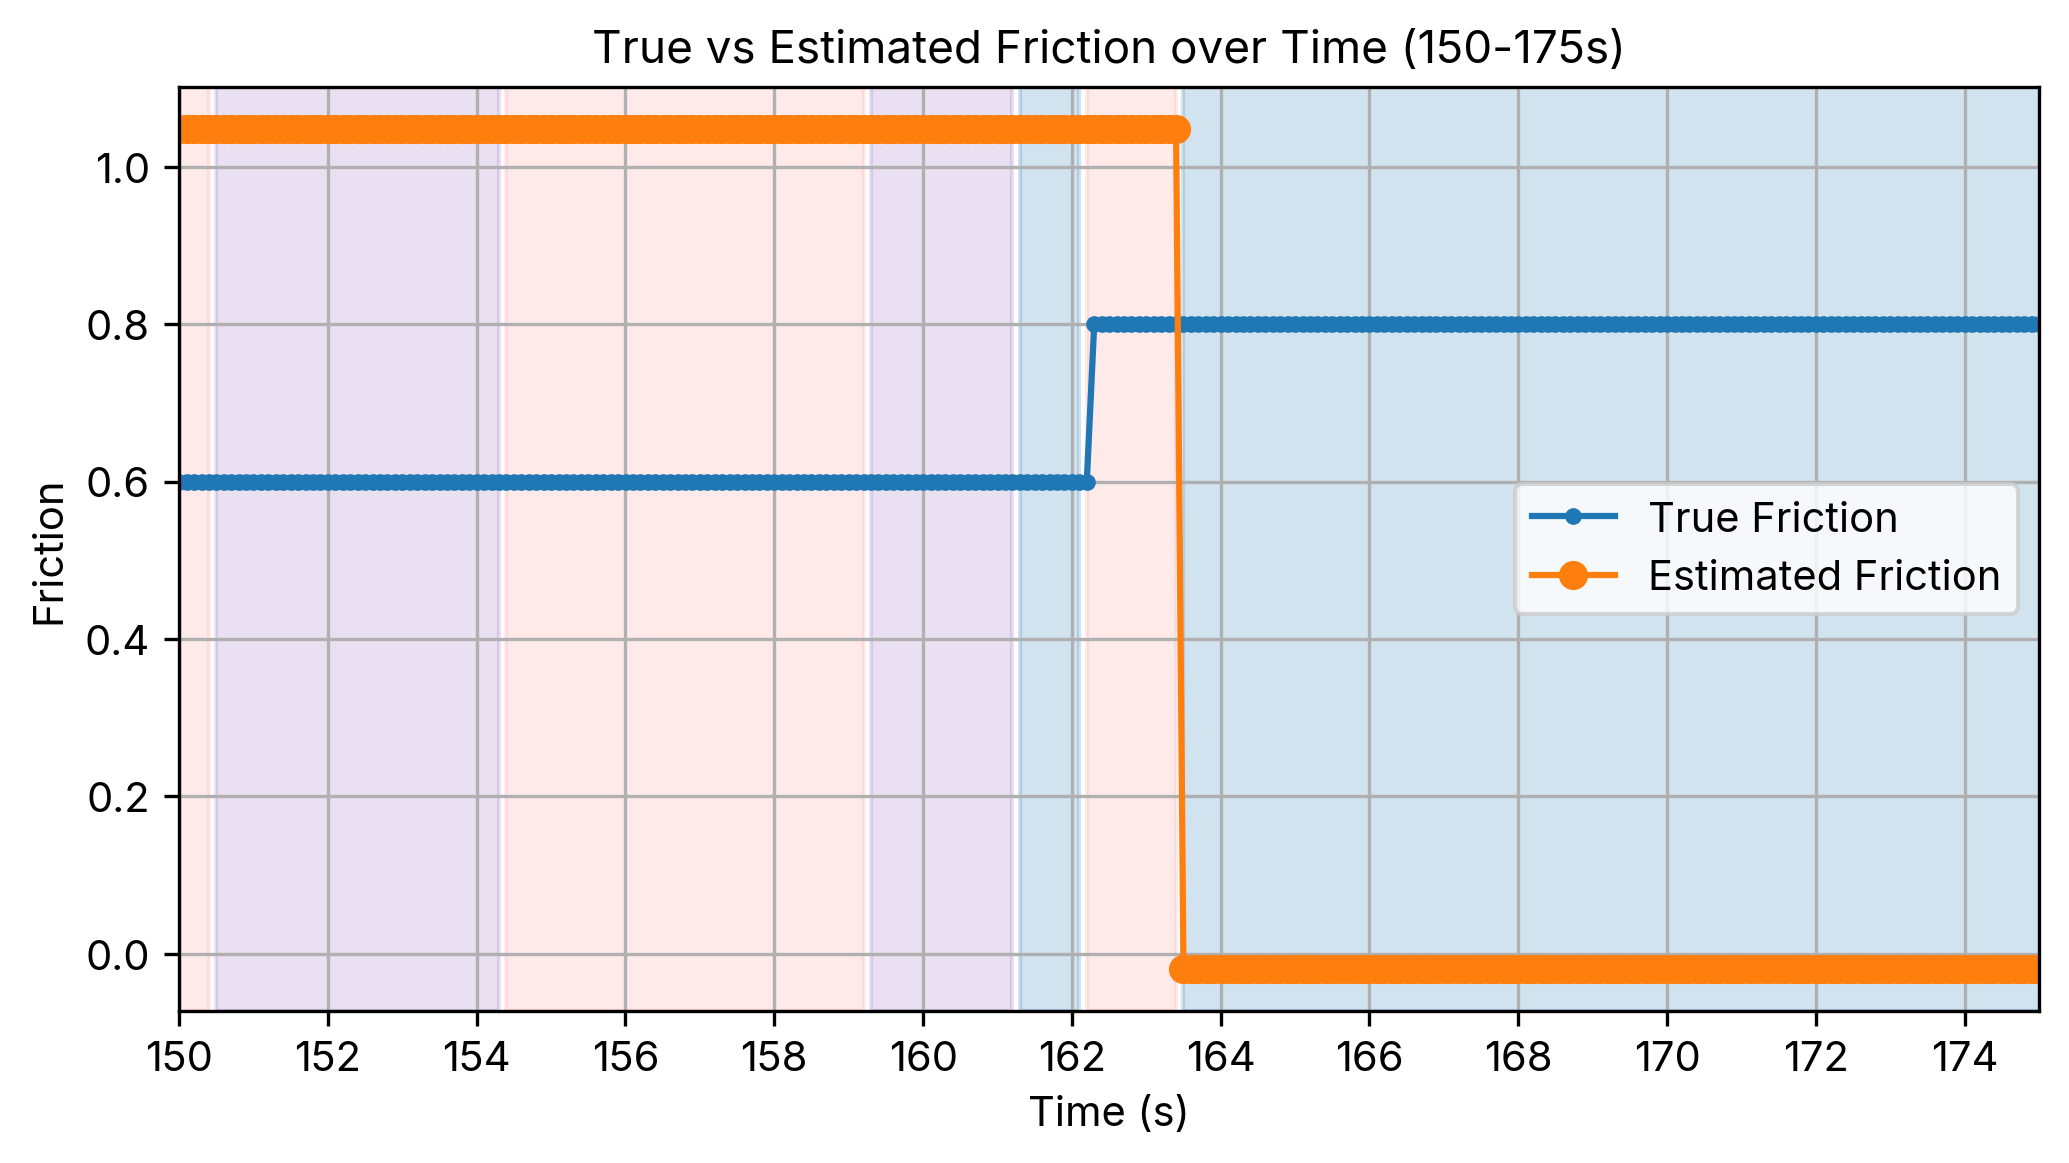

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(df['time'], df['ground_truth'], label='True Friction', marker='.')
plt.plot(df['time'], df['estimate'], label='Estimated Friction', marker='o')
plt.xlabel("Time (s)")
plt.ylabel("Friction")
plt.title("True vs Estimated Friction over Time (150-175s)")
plt.grid(True)

# Shade contiguous segments based on cluster values
current_cluster = df['cluster'].iloc[0]
start_time = df['time'].iloc[0]
for i in range(1, len(df)):
    if df['cluster'].iloc[i] != current_cluster:
        end_time = df['time'].iloc[i - 1]
        plt.axvspan(start_time, end_time, color=cluster_color_map[current_cluster], alpha=0.2)
        current_cluster = df['cluster'].iloc[i]
        start_time = df['time'].iloc[i]
# Shade the final segment
end_time = df['time'].iloc[-1]
plt.axvspan(start_time, end_time, color=cluster_color_map[current_cluster], alpha=0.2)
plt.xticks(np.arange(150, 175.1, 2))
plt.xlim(150, 175)
plt.legend(loc='center right')
plt.savefig("friction_estimates_zoomed.pdf", dpi=300, bbox_inches='tight')
plt.show()